In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

SPEC_START = 300
SPEC_END = 800
SPEC_STEP = 1
SPEC_WL = np.arange(SPEC_START, SPEC_END, SPEC_STEP)

# Utilities

Loading measured reradiation matrices from a BFC file.

In [2]:
def load_reradiation(filename: str) -> np.array:
    rerad = []

    # Read BFC file
    with open(filename, 'r') as f:
        line_number = 0
        for line in f:
            line_number += 1

            end_of_data = line.startswith('EOD') # Last line of BFC

            if line_number < 11:
                pass
            elif line_number == 11:
                # We parse the sampling and boundaries
                (wl_o_start,
                    wl_o_end,
                    wl_o_sampling,
                    wl_i_n_samples,
                    wl_i_start,
                    wl_i_sampling) = [int(el) for el in line.split()]

                wl_o_n_samples = int((wl_o_end - wl_o_start) / wl_o_sampling) + 1
                wl_i_end       = wl_i_start + (wl_i_n_samples - 1) * wl_i_sampling

            elif line_number > 12 and not end_of_data:
                # Populate the data
                read_data = [float(el) for el in line.split()[1:]]

                # This avoids a bug in file having an empty line in the middle of data
                if (len(read_data) > 0):
                    rerad.append(read_data)

        rerad = np.reshape(rerad, (wl_o_n_samples, wl_i_n_samples)).T

        # Remove negative values
        rerad[rerad < 0] = 0

        wl_i = np.linspace(wl_i_start, wl_i_end, wl_i_n_samples)
        wl_o = np.linspace(wl_o_start, wl_o_end, wl_o_n_samples)

        # Extract the diagonal
        # note this is not exact since the sampling in wl_i and wl_o may differ
        assert(wl_i_sampling == wl_o_sampling)
        start_wl = max(wl_i_start, wl_o_start)
        idx_start_wl_i = int(np.floor(start_wl - wl_i_start) // wl_i_sampling)
        idx_start_wl_o = int(np.floor(start_wl - wl_o_start) // wl_o_sampling)

        diag_wl  = np.zeros((wl_i_n_samples - idx_start_wl_i,))
        diag_val = np.zeros((wl_i_n_samples - idx_start_wl_i,))

        for idx_i, idx_o in zip(range(idx_start_wl_i, wl_i_n_samples),
                                range(idx_start_wl_o, wl_o_n_samples)):
            i = idx_i - idx_start_wl_i
            diag_wl [i] = start_wl + i * wl_i_sampling
            diag_val[i] = rerad[idx_i, idx_o]

            rerad[idx_i, idx_o] = 0

        # Interpolate with a 1nm step
        matrix_temp = np.zeros((SPEC_WL.shape[0], rerad.shape[1]))

        for j in range(rerad.shape[1]):
            matrix_temp[:,j] = np.interp(SPEC_WL, wl_i, rerad[:,j], left=0, right=0) / (wl_i[1] - wl_i[0]) * (SPEC_WL[1] - SPEC_WL[0])

        rerad = np.zeros((SPEC_WL.shape[0], SPEC_WL.shape[0]))

        for i in range(matrix_temp.shape[0]):
            rerad[i,:] = np.interp(SPEC_WL, wl_o, matrix_temp[i,:], left=0, right=0)

        # Restore diaognal
        rerad += np.diag(np.interp(SPEC_WL, diag_wl, diag_val, left=0, right=0))

        return rerad

Loading spectra from CSV files

In [3]:
def load_spectrum(filename: str) -> np.array:
    spec = np.loadtxt(filename, delimiter=',')
    spec_interp = np.interp(SPEC_WL, spec[:, 0], spec[:, 1], left=0, right=0)

    return spec_interp

In [4]:
def load_cmf(filename: str) -> np.array:
    cmf = np.loadtxt(filename, delimiter=',')

    # Interpolate (may be multiple spectra in case of CMF)
    cmf_interp = np.zeros((len(SPEC_WL), cmf.shape[1] - 1))

    for i in range(cmf.shape[1] - 1):
        cmf_interp[:, i] = np.interp(SPEC_WL, cmf[:, 0], cmf[:, i + 1], left=0, right=0)

    return cmf_interp

Color transformation utilities

In [5]:
def to_sRGB_gamma(C):
    C = np.clip(C, 0., 1.)

    if abs(C) < 0.0031308:
        return 12.92 * C
    return 1.055 * C**0.41666 - 0.055


# Converts a XYZ value to linear sRGB
def sRGB_from_XYZ(xyz: np.array) -> np.array:
    mat_sRGB = np.array([
        [ 3.2404542, -0.9692660, 0.0556434],
        [-1.5371385, 1.8760108, -0.2040259],
        [-0.4985314, 0.0415560, 1.0572252]
        ])

    return xyz[:3] @ mat_sRGB


def sRGB_gamma_from_XYZ(xyz, EV=0):
    rgb = sRGB_from_XYZ(xyz * 2**EV)

    return np.array([
        to_sRGB_gamma(rgb[0]),
        to_sRGB_gamma(rgb[1]),
        to_sRGB_gamma(rgb[2])
    ])

# Reradiation reduction

Naive reduction

In [6]:
def reduce_matrix_naive(fluo: np.array, cmf: np.array) -> np.array:
    T_spec_to_cmf = cmf.copy()
    T_spec_to_cmf_N = T_spec_to_cmf / np.sum(T_spec_to_cmf, axis=0)

    return T_spec_to_cmf_N.T @ fluo @ T_spec_to_cmf

Our matrix reduction.

In [7]:
def reduce_matrix_ours(fluo: np.array, cmf: np.array) -> np.array:
    T_spec_to_cmf = cmf.copy()
    T_cmf_to_spec = np.linalg.inv(T_spec_to_cmf.T @ T_spec_to_cmf) @ T_spec_to_cmf.T

    return T_cmf_to_spec @ fluo @ T_spec_to_cmf

# Comparison

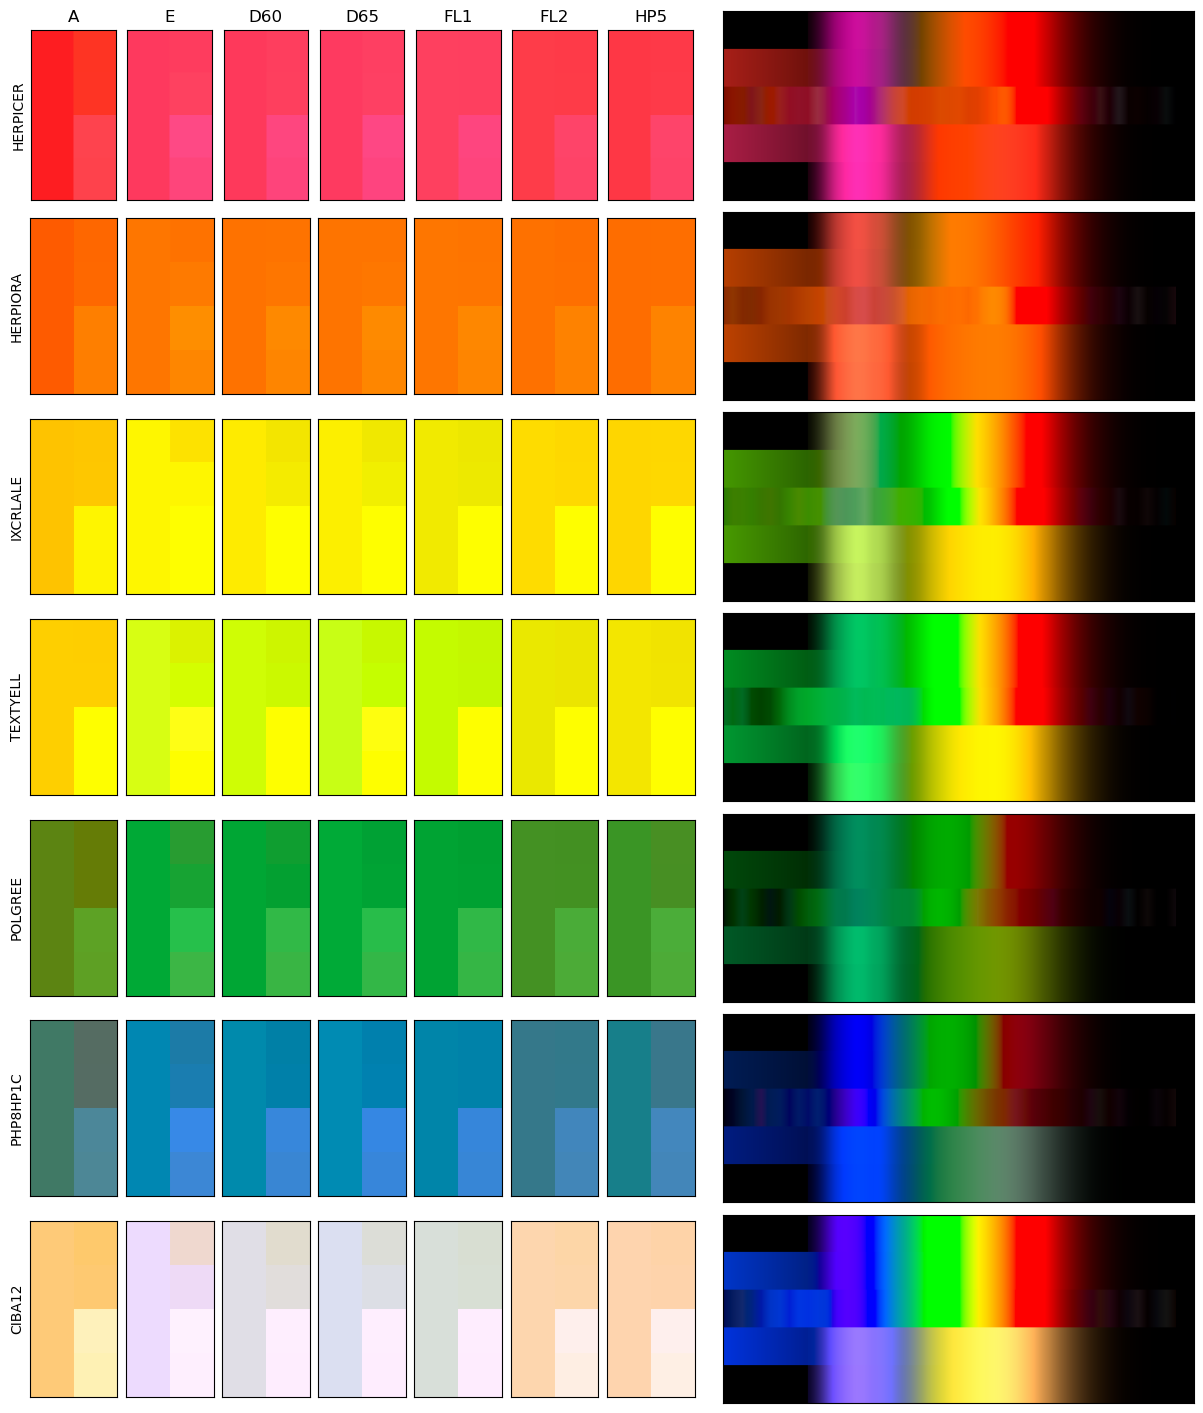

In [8]:
test_illu = ['A', 'E', 'D60', 'D65', 'FL1', 'FL2', 'HP5']
test_fluo = ['HERPICER', 'HERPIORA', 'IXCRLALE', 'TEXTYELL', 'POLGREE', 'PHP8HP1C', 'CIBA12']

cmf_xyz  = load_cmf(os.path.join('assets', 'CMF', 'ciexyz06_2deg.csv'))
cmf_xyzu = load_cmf(os.path.join('assets', 'CMF', 'xyzu.csv'))

width, height = 100, 200

fig = plt.figure(layout='constrained', figsize=((width * len(test_illu) + len(SPEC_WL)) / 100, height * len(test_fluo) / 100))
ysubfigs = fig.subfigures(len(test_fluo), 1)

for i_fluo, name_fluo in enumerate(test_fluo):
    spec_fluo = load_reradiation(os.path.join('assets', 'fluo', f'{name_fluo}.BFC'))

    xsubfigs = ysubfigs[i_fluo].subfigures(1, 2, width_ratios=[width * len(test_illu), len(SPEC_WL)])
    ax = xsubfigs[0].subplots(1, len(test_illu))

    ax[0].set_ylabel(name_fluo)

    # Standard illuminants
    for i_illu, name_illu in enumerate(test_illu):
        im = np.zeros((height, width, 3))

        spec_illu = load_spectrum(os.path.join('assets', 'illuminant', f'illuminant_{name_illu}.csv'))

        # Adapt illu intensity to have a target Y value
        xyz_illu  = spec_illu @ cmf_xyz  * SPEC_STEP
        spec_illu /=  1.2 * xyz_illu[1]
        xyz_illu  = spec_illu @ cmf_xyz  * SPEC_STEP
        xyzu_illu = spec_illu @ cmf_xyzu * SPEC_STEP

        xyz_fluo_ours   = reduce_matrix_ours (spec_fluo, cmf_xyz)
        xyzu_fluo_ours  = reduce_matrix_ours (spec_fluo, cmf_xyzu)
        xyz_fluo_naive  = reduce_matrix_naive(spec_fluo, cmf_xyz)
        xyzu_fluo_naive = reduce_matrix_naive(spec_fluo, cmf_xyzu)

        # Reference
        im[:, :width//2] = sRGB_gamma_from_XYZ(spec_illu @ spec_fluo @ cmf_xyz)

        # Reduction
        im[0*height//4:1*height//4, width//2:] = sRGB_gamma_from_XYZ(xyz_illu  @ xyz_fluo_ours)
        im[1*height//4:2*height//4, width//2:] = sRGB_gamma_from_XYZ(xyzu_illu @ xyzu_fluo_ours)
        im[2*height//4:3*height//4, width//2:] = sRGB_gamma_from_XYZ(xyzu_illu @ xyzu_fluo_naive)
        im[3*height//4:4*height//4, width//2:] = sRGB_gamma_from_XYZ(xyz_illu  @ xyz_fluo_naive)

        ax[i_illu].imshow(im)

        if i_fluo == 0:
            ax[i_illu].set_title(name_illu)

        ax[i_illu].set_xticks([])
        ax[i_illu].set_yticks([])

    # Monochromatic swipe
    im = np.zeros((height, len(SPEC_WL), 3))

    for i, wl in enumerate(SPEC_WL):
        spec_illu = np.zeros(len(SPEC_WL))
        spec_illu[i] = 1

        xyz_illu  = spec_illu @ cmf_xyz  * SPEC_STEP
        xyzu_illu = spec_illu @ cmf_xyzu * SPEC_STEP

        im[0*height//5:1*height//5, i] = sRGB_gamma_from_XYZ(xyz_illu  @ xyz_fluo_ours)
        im[1*height//5:2*height//5, i] = sRGB_gamma_from_XYZ(xyzu_illu @ xyzu_fluo_ours)
        im[2*height//5:3*height//5, i] = sRGB_gamma_from_XYZ(spec_illu @ spec_fluo @ cmf_xyz)
        im[3*height//5:4*height//5, i] = sRGB_gamma_from_XYZ(xyzu_illu @ xyzu_fluo_naive)
        im[4*height//5:5*height//5, i] = sRGB_gamma_from_XYZ(xyz_illu  @ xyz_fluo_naive)

    ax = xsubfigs[1].subplots(1, 1)
    ax.imshow(im, extent=[SPEC_START, SPEC_END, 0, height])
    ax.set_yticks([])
    ax.set_xticks([])

plt.show()